In [4]:
# emonstrating your findings using a data visualization tool

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [104]:
df = pd.read_csv("2020-XTern-DS.csv")

In [105]:
df.isnull().sum()
# No missing value

Restaurant       0
Latitude         0
Longitude        0
Cuisines         0
Average_Cost     0
Minimum_Order    0
Rating           0
Votes            0
Reviews          0
Cook_Time        0
dtype: int64

In [106]:
# There are missing value ('-') and Opening Soon and New => group them into one
def grouping_noneRating(rating):
    if(rating == 'NEW' or rating == 'Opening Soon' or rating == '-'):
        return 0
    else:
        return float(rating)

In [107]:
df['Average_Cost'] = pd.to_numeric(df.apply(lambda x: x['Average_Cost'].replace('$','').replace(',','.'), axis = 1),errors='coerce')

df['Minimum_Order'] = pd.to_numeric(df.apply(lambda x: x['Minimum_Order'].replace('$',''), axis = 1),errors='coerce')

df['Cook_Time'] = pd.to_numeric(df.apply(lambda x: x['Cook_Time'][0:2], axis = 1),errors='coerce')

df['Rating'] = df.apply(lambda x: grouping_noneRating(x['Rating']), axis = 1)

df['Votes'] = df.apply(lambda x: grouping_noneRating(x['Votes']), axis = 1)

df['Reviews'] = df.apply(lambda x: grouping_noneRating(x['Reviews']), axis = 1)

In [108]:
# trying to identify the trending restaurants with your own scoring algorithm
# (can be as simple as the best rating or most votes or both!)
trending_place = df.copy()

In [109]:
C = np.average(trending_place['Rating'])
m = np.average(trending_place['Reviews'])
def calculating_ratingScore(R, v):
    w = v/(v+m)
    return ((w*R) + (1-w)*C)

In [110]:
# S = wR + (1-w)C
# S = score of the restaurant
# R = average of user ratings for the restaurant
# C = average of user ratings for all restaurants
# w = weight assigned to R and computed as v/(v+m), where v is the number of user ratings 
# for that restaurant, and m is average number of reviews for all restaurants.
# http://www.ebc.cat/2015/01/05/how-to-rank-restaurants/

In [111]:
trending_place['trending'] = trending_place.apply(lambda x: calculating_ratingScore(x['Rating'],x['Votes']), axis = 1)

In [112]:
trending_place.sort_values(['trending'], ascending=False).head()

,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time,trending
1180,ID_1064,39.587777,-85.564805,"Continental, North Indian, BBQ, Steak",80.0,50.0,4.7,9054.0,6504.0,45,4.680970
1428,ID_2051,39.759886,-85.500507,"Italian, Continental, Chinese, Mexican, Fast F...",30.0,50.0,4.7,3975.0,2359.0,65,4.657257
1300,ID_1666,39.959980,-85.903329,"Mexican, American, Italian, Burger",50.0,99.0,4.6,4903.0,3989.0,65,4.567206
1501,ID_7924,39.541385,-85.588979,"North Indian, Chinese, Kebab, Mughlai",80.0,50.0,4.7,1112.0,972.0,45,4.556390
1325,ID_4728,39.135109,-85.830490,"North Indian, Mughlai, Biryani, Rolls, Momos",25.0,99.0,4.8,650.0,423.0,45,4.554595


In [113]:
# clustering restaurant locations to figure out the 
# optimized FoodieX pick up zones
# Using the old simple K-Means Clustering technique

In [114]:
cluster_df = df.copy()
cluster_df = cluster_df[['Restaurant','Latitude','Longitude']]

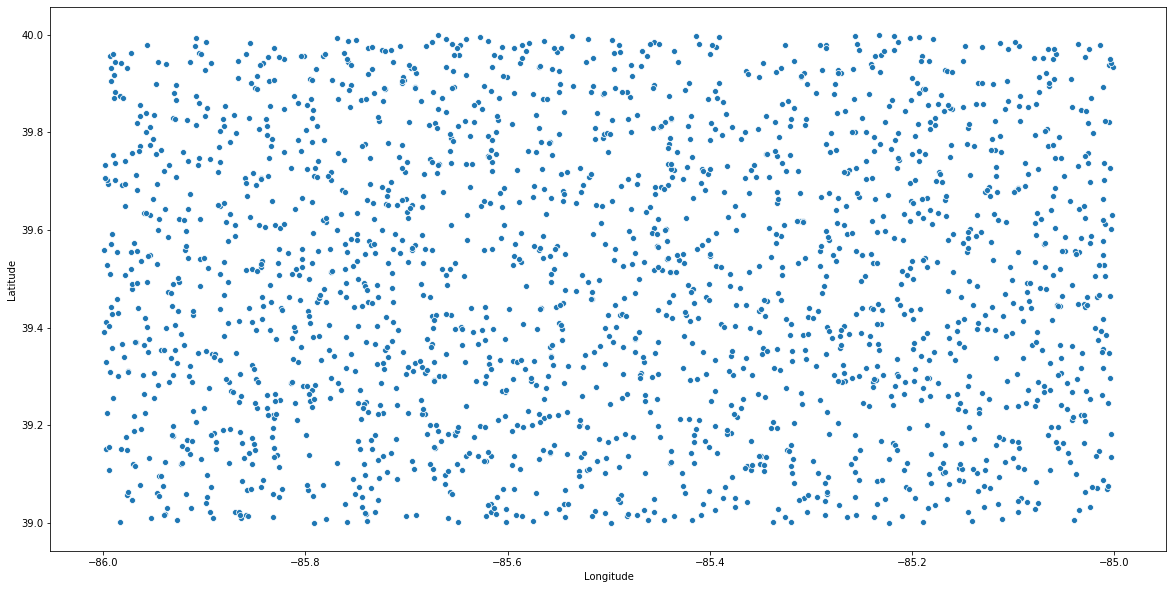

In [115]:
plt.figure(figsize=(20,10))
sns.scatterplot(x = cluster_df['Longitude'], y = cluster_df['Latitude'])

In [116]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(cluster_df.drop('Restaurant', axis = 1))

geometry = scaler.transform(cluster_df.drop('Restaurant', axis=1))

In [117]:
from sklearn.cluster import KMeans

In [118]:
geometry

array([[-0.82791767, -1.15002235],
       [ 0.96889219, -0.81663114],
       [-0.86001339,  1.30790527],
       ...,
       [ 0.57354732, -1.54103961],
       [-0.69084535, -0.548609  ],
       [-0.13366999,  0.06592407]])

In [119]:
# Testing to see the "elbow" or the suitable k-value
sumOfEachCluster = []
for i in range(1,11):
    model = KMeans(n_clusters=i, random_state=42)
    model.fit(geometry)
    sumOfEachCluster.append(model.inertia_)

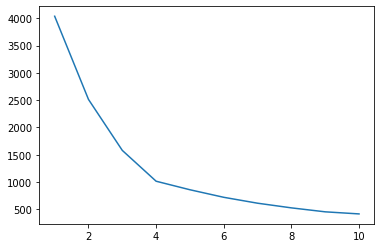

In [120]:
plt.plot(range(1,11),sumOfEachCluster)

In [121]:
model = KMeans(n_clusters=4, random_state=42)
y_clusters = model.fit_predict(geometry)

Text(0, 0.5, 'Latitude')

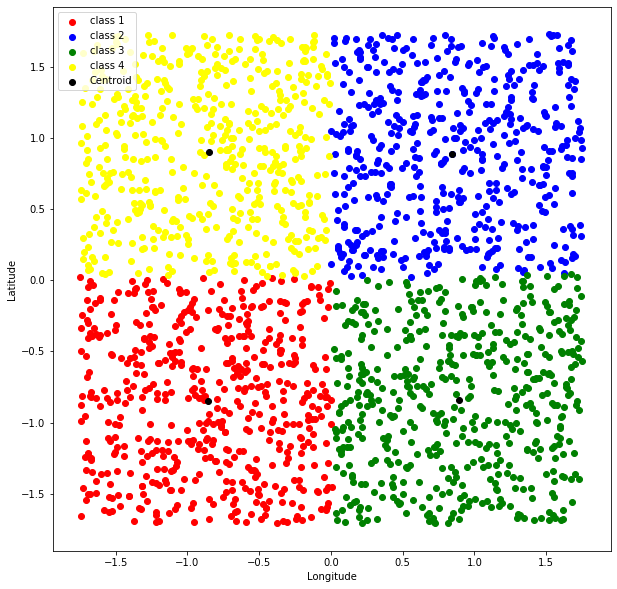

In [122]:
plt.figure(figsize=(10,10))
plt.scatter(geometry[y_clusters==0,0],geometry[y_clusters==0,1],c='red',label='class 1')
plt.scatter(geometry[y_clusters==1,0],geometry[y_clusters==1,1],c='blue',label='class 2')
plt.scatter(geometry[y_clusters==2,0],geometry[y_clusters==2,1],c='green',label='class 3')
plt.scatter(geometry[y_clusters==3,0],geometry[y_clusters==3,1],c='yellow',label='class 4')
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], c='black',label='Centroid')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [123]:
center_geometry = pd.DataFrame(model.cluster_centers_[:,0],columns=['Longitude'])

In [124]:
center_geometry['Latitude'] = model.cluster_centers_[:,1]

In [125]:
center_geometry = scaler.inverse_transform(center_geometry)

In [126]:
center_geometry = pd.DataFrame((center_geometry), columns=['Latitude','Longitude'])

In [127]:
center_geometry

,Latitude,Longitude
0,39.253635,-85.749958
1,39.739481,-85.245798
2,39.754040,-85.748076
3,39.255467,-85.242617


In [128]:
import reverse_geocoder as rg 
import pprint 

In [129]:
def reverseGeocode(lat,long): 
    coordinates = (lat,long)
    result = rg.search(coordinates) 
    pprint.pprint(result)  

In [130]:
center_geometry.apply(lambda x: reverseGeocode(x['Latitude'],x['Longitude']),axis=1)

[{'admin1': 'Indiana',
  'admin2': 'Bartholomew County',
  'cc': 'US',
  'lat': '39.30394',
  'lon': '-85.77137',
  'name': 'Hope'}]
[{'admin1': 'Indiana',
  'admin2': 'Wayne County',
  'cc': 'US',
  'lat': '39.81255',
  'lon': '-85.17163',
  'name': 'Cambridge City'}]
[{'admin1': 'Indiana',
  'admin2': 'Hancock County',
  'cc': 'US',
  'lat': '39.78504',
  'lon': '-85.76942',
  'name': 'Greenfield'}]
[{'admin1': 'Indiana',
  'admin2': 'Ripley County',
  'cc': 'US',
  'lat': '39.30005',
  'lon': '-85.22218',
  'name': 'Batesville'}]


0    None
1    None
2    None
3    None
dtype: object

In [131]:
# estimating cook time based on restaurant info
# we do not need Latitude, Longitude, Cuisines and Reviews to estimate Cooking time

In [132]:
cooktime_df = df.copy()
cooktime_df.drop(['Latitude','Longitude','Cuisines','Reviews'],axis=1, inplace=True)

In [133]:
cooktime_df.head()

,Restaurant,Average_Cost,Minimum_Order,Rating,Votes,Cook_Time
0,ID_6321,20.0,50.0,3.5,12.0,30
1,ID_2882,10.0,50.0,3.5,11.0,30
2,ID_1595,15.0,50.0,3.6,99.0,65
3,ID_5929,25.0,99.0,3.7,176.0,30
4,ID_6123,20.0,99.0,3.2,521.0,65


In [134]:
cooktime_df.dtypes
# Changing everything into float64 and int64 data type

Restaurant        object
Average_Cost     float64
Minimum_Order    float64
Rating           float64
Votes            float64
Cook_Time          int64
dtype: object

In [135]:
cooktime_df.corr()
# The correlation between cook_time and other factors are too small to compute accurately

,Average_Cost,Minimum_Order,Rating,Votes,Cook_Time
Average_Cost,1.000000,0.203981,0.275202,0.421366,0.240988
Minimum_Order,0.203981,1.000000,0.087759,0.146039,0.207851
Rating,0.275202,0.087759,1.000000,0.292901,0.258616
Votes,0.421366,0.146039,0.292901,1.000000,0.255479
Cook_Time,0.240988,0.207851,0.258616,0.255479,1.000000


In [136]:
X = cooktime_df.drop(['Cook_Time','Restaurant'],axis=1)
y = cooktime_df['Cook_Time']

In [137]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X)

X = scaler.transform(X)

Text(0, 0.5, 'Minutes')

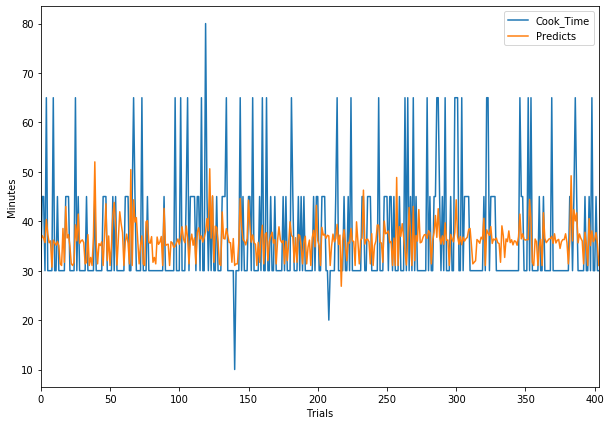

In [138]:
# in Multiple Regression there is no need to do feature scaling

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train,y_train)

predicts = model.predict(X_test)

val = pd.DataFrame(y_test)

val['Predicts'] = predicts

val.index=np.arange(len(val))

val.plot(figsize=(10,7))
plt.xlabel('Trials')
plt.ylabel('Minutes')